In [23]:
import sys
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import skimage
import skimage.io as io

from skimage.morphology import disk
from skimage.feature import blob_log
from skimage.filters import gaussian


sys.path.append('../../src')
import viz
import log_blobs_detector 
import traj_descriptors as td

import trackpy

import warnings
warnings.filterwarnings('ignore')

## File Log

In [24]:
file_LOG="../../results/Analysized_experiments.csv"
file_Log=pd.read_csv(file_LOG,sep=";")
file_Log["omeroID"]=file_Log["omeroID"].astype('str')
file_Log=file_Log.set_index("omeroID")
file_Log

file_prefix  duration_frames  \
omeroID                                                                       
nan                                 2021May19_8ml_kb_wt-01             41.0   
nan                          2021May3_8ml_kb_RedGlyc_ON-02             21.0   
nan                         2021May6_8ml_kb_RedGlyc_day-01             33.0   
nan                          2021Apr21_8ml_kb_wtglyc_ON-02             48.0   
nan                          2021May18_8ml_kb_Dwss-01MOVIE             41.0   
nan                                 2021May24_8ml_kb_wt-01             43.0   
nan                                                    NaN              NaN   
43113.0  2021Feb16_6wellplate_lid_8ml_kb_aliquot_glyc_W...            138.0   
43116.0  2021Feb16_6wellplate_lid_8ml_kb_aliquot_glyc_W...             37.0   
43117.0  2021Feb17_6wellplate_lid_8ml_kb_aliquot_glyc_W...             35.0   
43118.0  2021Feb17_6wellplate_lid_8ml_kb_aliquot_glyc_W...            128.0   
43047.0  2021Feb15_6wellplate_lid_8ml_kb_aliquot_glyc_W...             49.0   

         dx_micron  dy_micron    dt_s  Nrows_px  Ncols_px  
omeroID                                                    
nan         12.971     12.971  1800.0    2208.0    2752.0  
nan         12.971     12.971  1800.0    2208.0    2752.0  
nan         12.971     12.971  1800.0    2208.0    2752.0  
nan         12.971     12.971  1200.0    2208.0    2752.0  
nan         12.971     12.971  1800.0    2208.0    2752.0  
nan         12.971     12.971  1800.0    2208.0    2752.0  
nan            NaN        NaN     NaN       NaN       NaN  
43113.0     12.971     12.971   300.0    2208.0    2752.0  
43116.0     12.971     12.971  1200.0    2208.0    2752.0  
43117.0     12.971     12.971  1200.0    2208.0    2752.0  
43118.0     12.971     12.971   300.0    2208.0    2752.0  
43047.0     12.971     12.971   300.0    2208.0    2752.0

## Read Detected_blobs 

In [25]:
FileList=glob('../../results/Detected_blobs_*.csv')
FileList

['../../results/Detected_blobs_2021Feb17_6wellplate_lid_8ml_kb_aliquot_glyc_WT-04.czi.csv',
 '../../results/Detected_blobs_2021Apr21_8ml_kb_wtglyc_ON-02.csv',
 '../../results/Detected_blobs_2021Feb16_6wellplate_lid_8ml_kb_aliquot_glyc_WT-01_overnight.czi".csv',
 '../../results/Detected_blobs_2021May3_8ml_kb_RedGlyc_ON-02.csv',
 '../../results/Detected_blobs_2021Feb16_6wellplate_lid_8ml_kb_aliquot_glyc_WT-01.czi.csv',
 '../../results/Detected_blobs_2021May24_8ml_kb_wt-01.csv',
 '../../results/Detected_blobs_2021May19_8ml_kb_wt-01.csv',
 '../../results/Detected_blobs_2021May18_8ml_kb_Dwss-01MOVIE.csv',
 '../../results/Detected_blobs_2021Feb15_6wellplate_lid_8ml_kb_aliquot_glyc_WT-02.czi.csv',
 '../../results/Detected_blobs_2021Feb17_6wellplate_lid_8ml_kb_aliquot_glyc_WT-03_overnight.czi.csv',
 '../../results/Detected_blobs_2021May6_8ml_kb_RedGlyc_day-01.csv']

## Bobs filter


### Read data.

In [26]:
Contrast=0.06
Blobs_all_experiments=pd.DataFrame()
for file in FileList:
    df=pd.read_csv(file)
    df=df[df["contrast"]>Contrast]
    Blobs_all_experiments=pd.concat([Blobs_all_experiments,df])
    


###  Select May experiments

In [27]:
ListFiles=["2021May19_8ml_kb_wt-01","2021May3_8ml_kb_RedGlyc_ON-02","2021May6_8ml_kb_RedGlyc_day-01","2021May18_8ml_kb_Dwss-01MOVIE","2021May24_8ml_kb_wt-01"]
ListFiles
Blobs_all_experiments=Blobs_all_experiments.loc[Blobs_all_experiments['file_prefix'].isin(ListFiles)]

### Time shift
* 2021May3 10 hours
* 2021May6 10 hours

In [28]:
def time_shift(df,experiment_name,time_shift_min,dt_s):
    selection=df['file_prefix']==experiment_name
    df.loc[selection,'time_min']=df.loc[selection,'time_min']+time_shift_min
    frame_shift=int(time_shift_min*60/dt_s)
    print(frame_shift)
    df.loc[selection,'frame']=df.loc[selection,'frame']+frame_shift
    return df

In [29]:
# Blobs_all_experiments=time_shift(Blobs_all_experiments,'2021May3_8ml_kb_RedGlyc_ON-02',10*60,1800)
# Blobs_all_experiments=time_shift(Blobs_all_experiments,'2021May6_8ml_kb_RedGlyc_day-01',10*60,1800)

In [30]:
Blobs_all_experiments[Blobs_all_experiments['file_prefix']=='2021May3_8ml_kb_RedGlyc_ON-02'].frame.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

### Cut off declined part
#### Colony counter


In [31]:
def blobs_counter(df):
    Count=df.groupby(['time_min']).apply(lambda x: len(x['radius']))
    A=Count.reset_index('time_min')
    A=A.rename(columns={A.columns[1]:"Count"})
    A['Count_correct']=A['Count']-A['Count'].iloc[0]
    return A


df_Counter=pd.DataFrame()
for id, group in  Blobs_all_experiments.groupby("file_prefix"):
    df_counter=blobs_counter(group)
    df_counter["file_prefix"]=id
    #df_counter['time']=df_counter['frame']*dt
    df_Counter=pd.concat([df_Counter,df_counter])

#### Peak of colony counter

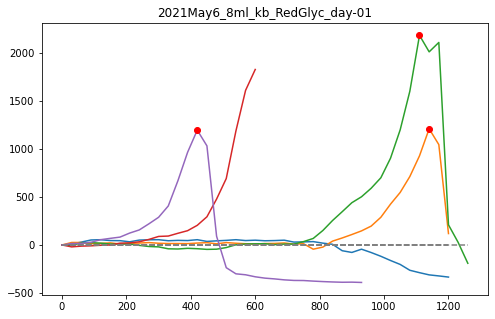

In [32]:
from scipy.signal import find_peaks

df_peaks=[]
stop_frame_dict={}
df_Counter_incr_part=pd.DataFrame()
fig,ax=plt.subplots(figsize=(8,5))
for id, group in  df_Counter.groupby("file_prefix"):
    x=group['Count_correct'].values
    t=group['time_min'].values
    
    peaks, _ = find_peaks(x, height=1000,width=3)
    
    ax.plot(t,x)
    ax.plot(t[peaks], x[peaks],"or")
    ax.plot(t,np.zeros_like(x), "--", color="gray")
    ax.set_title(id)
    
    if peaks:
        peak=peaks[0]
        file_peaks={"file_prefix":id,"peak_t_min":t[peak],"peak_number_colonies":x[peak]}
        df_peaks.append(file_peaks)
        df_new=group[group['time_min']<t[peak]]
        stop_frame_dict.update({id:t[peak]})
    else:
        df_new=group
        stop_frame_dict.update({id:df_new['time_min'].max()})
    
    group['file_prefix']=id
    
    df_Counter_incr_part=pd.concat([df_Counter_incr_part,df_new])
    
    
df_peaks=pd.DataFrame(df_peaks)

In [33]:
stop_frame_dict.update({'2021May18_8ml_kb_Dwss-01MOVIE':1200})

In [34]:
stop_frame_dict

{'2021May18_8ml_kb_Dwss-01MOVIE': 1200,
 '2021May19_8ml_kb_wt-01': 1140.0,
 '2021May24_8ml_kb_wt-01': 1110.0,
 '2021May3_8ml_kb_RedGlyc_ON-02': 600.0,
 '2021May6_8ml_kb_RedGlyc_day-01': 420.0}

### Tracking

In [35]:
Tracks=pd.DataFrame()

for file_id, group_file in Blobs_all_experiments.groupby('file_prefix'):
   
    for cut,group in group_file.groupby("cut"):
        print(file_id)
        # filter until stop time (peak in a counter)
        stop_time_min=stop_frame_dict[file_id]
        df_track=group[group['time_min']<stop_time_min].copy()
        df_track=df_track.rename(columns={"col":"x","row":"y"})
        tracks = trackpy.link_df(df_track,search_range=15)
        
        # filter out trajectories less than 3 frames
        clean_tracks = trackpy.filter_stubs(tracks,threshold=3)
        #rename back to my notation
        clean_tracks=clean_tracks.rename(columns={"x":"col","y":"row"})
        clean_tracks["cut"]=cut
        clean_tracks["file_prefix"]=file_id
        clean_tracks.to_csv("../../results/tracks_overlay_id_"+file_id+'.csv')
        Tracks=pd.concat([Tracks,clean_tracks])

Frame 13: 318 trajectories present.


In [36]:
for id, group in Tracks.groupby('file_prefix'):
    print(id)

2021May18_8ml_kb_Dwss-01MOVIE
2021May19_8ml_kb_wt-01
2021May24_8ml_kb_wt-01
2021May3_8ml_kb_RedGlyc_ON-02
2021May6_8ml_kb_RedGlyc_day-01


### Create animation

##### read images

In [48]:
import pickle
infile = open("../../results/AprilMay_image_cuts",'rb')
images_dict= pickle.load(infile)
infile.close()

In [52]:
images_dict['2021May19_8ml_kb_wt-01'].keys()

dict_keys(['img', 'dx', 'dt', 'Nrows', 'Ncols', 'cuts'])

In [39]:
def plot_scale_bar(ax,px_micron=1.42,size=500):
    n_pixels=size/px_micron
    rows,cols=images.shape[1],images.shape[2]
    col_start=(cols-n_pixels)-500
    row_start=(rows-100)
    ax.plot([col_start,col_start+n_pixels],[row_start,row_start],color='cyan')
    ax.text(col_start+1,row_start-25,s="{} micron".format(size),color="cyan")
    print(n_pixels)

In [53]:
file_prefix='2021May19_8ml_kb_wt-01'

###========================================####
cut_1=images_dict[file_prefix]["cuts"][0]

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera

sns.set(font_scale=1.5)

fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,10),constrained_layout=True)
ax[0].set_title("{} \n data".format(file_prefix))
ax[0].axis("off")


ax[1].set_title("segmented")
ax[1].axis("off")



nFrames=cut_1.shape[0]
camera = Camera(fig)

for frame in range(nFrames):
    ax[0].imshow(cut_1[frame],cmap='gray')
    plot_scale_bar(ax[0],px_micron=1.42)
    ax[1].imshow(binary[frame],cmap='gray')
    ax[1].annotate('frame={}'.format(frame), xy=(0, 0),xytext=(0,-5))
    plot_scale_bar(ax[1],px_micron=1.42)
    
    # plot trajectories
    tracks_frame=tracks[tracks['frame']<=frame]
    for id,group in tracks_frame.groupby("particle"):
        ax[1].plot(group['x'],group['y'],lw=2,color='red')
    
    
    camera.snap()
    
animation = camera.animate()

# from IPython.display import HTML
# HTML(animation.to_html5_video())

animation.save('../results/{}_animation.mp4'.format(file_prefix))